# Preprocess word

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed_ = 20200218

np.random.seed(seed_)
tf.random.set_seed(seed_)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", 
              context="paper", 
              font='Dank Mono', 
              font_scale=1.25, 
              rc={"figure.figsize": (10.5, 4.5), "figure.dpi": 150, "grid.alpha": 0.5}
             )
_30k = ["#202f66", "#ff7048", "#7f68d0", "#f3d36e", "#d869ab", "#1b262c"]
sns.set_palette(_30k)

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_dark"

import wordcloud

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import nltk
from nltk.corpus import stopwords

In [5]:
import gensim

In [6]:
# tensorflow text preprocessing function

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Data

In [7]:
df = pd.read_json("./data/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [8]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Preprocess

In [9]:
stop_words = stopwords.words('english')

In [10]:
def preprocess_text(text, stop_words):
    tokenized = nltk.tokenize.word_tokenize(text.lower())
    
    # remove stop words
    tokenized = [token for token in tokenized if token not in stop_words]
    
    # remove punctuation
    tokenized = [token for token in tokenized if token.isalpha()]
    
    return tokenized

In [11]:
tokenized_texts = df['headline'].apply(preprocess_text, args=[stop_words])

In [12]:
tokenized_texts

0        [thirtysomething, scientists, unveil, doomsday...
1        [dem, totally, nails, congress, falling, short...
2          [eat, veggies, deliciously, different, recipes]
3        [inclement, weather, prevents, liar, getting, ...
4        [mother, comes, pretty, close, using, word, co...
                               ...                        
28614         [jews, celebrate, rosh, hashasha, something]
28615    [internal, affairs, investigator, disappointed...
28616    [beautiful, acceptance, speech, week, came, qu...
28617    [mars, probe, destroyed, orbiting, space, palace]
28618                         [dad, clarifies, food, stop]
Name: headline, Length: 28619, dtype: object

# Word Embedding

https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy/notebook#Introduction-to-Word-Embedding-and-Word2Vec

In [13]:
embedding_dims = 32

In [14]:
w2v = gensim.models.Word2Vec(sentences=np.array(tokenized_texts), size=embedding_dims,
                            window=5, min_count=1)

# Tensorflow/Tokenize

In [15]:
# tokenizer config

num_words = 20000

max_length = 20
pad_trunc = 'pre'

In [16]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(tokenized_texts)

word_index = tokenizer.word_index
index_word = {i: w for w, i in word_index.items()}

In [17]:
sequences = tokenizer.texts_to_sequences(tokenized_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating=pad_trunc)

padded_sequences[:4]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 14116,   233,  2855,  6803,  2361,
          531,   975],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  6804,   597,  2856,   131,  1688,   945,  1552,
         2001,  1553],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   739, 10321, 14117,
          481,  1270],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 10322,  1423,  5858,  4605,
           65,    72]])

In [18]:
for k, v in list(word_index.items())[:10]:
    print(f"{k}:\t{v}")
    
for k, v in list(index_word.items())[:10]:
    print(f"{k}:\t{v}")

trump:	1
new:	2
man:	3
report:	4
one:	5
woman:	6
area:	7
says:	8
day:	9
donald:	10
1:	trump
2:	new
3:	man
4:	report
5:	one
6:	woman
7:	area
8:	says
9:	day
10:	donald


In [19]:
vocab_size = len(word_index) + 1
vocab_size

24899

In [20]:
# get weights from w2v model

embedding_vecs = np.zeros((vocab_size, embedding_dims))

for word, index in word_index.items():
    embedding_vecs[index] = w2v[word]

In [21]:
embedding_vecs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.10113466e+00, -6.28200591e-01,  2.31044106e-02, ...,
        -2.91889280e-01,  2.03372526e+00, -2.21340942e+00],
       [ 9.66719806e-01, -4.87843305e-01, -2.64493644e-01, ...,
         2.39738256e-01,  1.73839664e+00, -2.49399304e+00],
       ...,
       [ 8.44890438e-03, -3.44779552e-03,  2.21067155e-03, ...,
         6.35295780e-03,  1.70984045e-02, -2.60090064e-02],
       [-1.44683290e-03, -1.17535992e-02,  3.10174888e-03, ...,
        -8.88734404e-03,  1.61415953e-02, -2.70280838e-02],
       [-3.44368769e-03, -1.00813936e-02,  9.08637326e-03, ...,
         2.22665258e-03,  8.67970102e-03, -1.97247397e-02]])

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, output_dim=embedding_dims, 
        weights=[embedding_vecs], input_length=max_length
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(16, activation='relu')
    ),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            796768    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 865,537
Trainable params: 865,537
Non-trainable params: 0
_________________________________________________________________


In [24]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [25]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## Split train test

In [26]:
df.shape

(28619, 3)

In [27]:
train_size = 20000

In [28]:
x_train = padded_sequences[:train_size]
x_test = padded_sequences[train_size:]
y_train = df['is_sarcastic'][:train_size]
y_test = df['is_sarcastic'][train_size:]

## train model

In [29]:
num_epochs = 5

In [30]:
hist = model.fit(x_train, y_train, 
          epochs=num_epochs, 
          batch_size=64, 
          validation_data=(x_test, y_test),
          verbose=1,
         )

Epoch 1/5
313/313 [==============================] - 50s 161ms/step - loss: 0.5179 - accuracy: 0.7325 - val_loss: 0.4245 - val_accuracy: 0.8059
Epoch 2/5
313/313 [==============================] - 50s 161ms/step - loss: 0.4043 - accuracy: 0.8960 - val_loss: 0.4659 - val_accuracy: 0.8000
Epoch 3/5
313/313 [==============================] - 49s 158ms/step - loss: 0.1114 - accuracy: 0.9590 - val_loss: 0.6891 - val_accuracy: 0.7854
Epoch 4/5
313/313 [==============================] - 51s 162ms/step - loss: 0.0498 - accuracy: 0.9811 - val_loss: 1.1851 - val_accuracy: 0.7697
Epoch 5/5
313/313 [==============================] - 51s 164ms/step - loss: 0.0323 - accuracy: 0.9891 - val_loss: 1.0056 - val_accuracy: 0.7806


## Plot loss

In [34]:
epochs = np.arange(1, num_epochs+1)

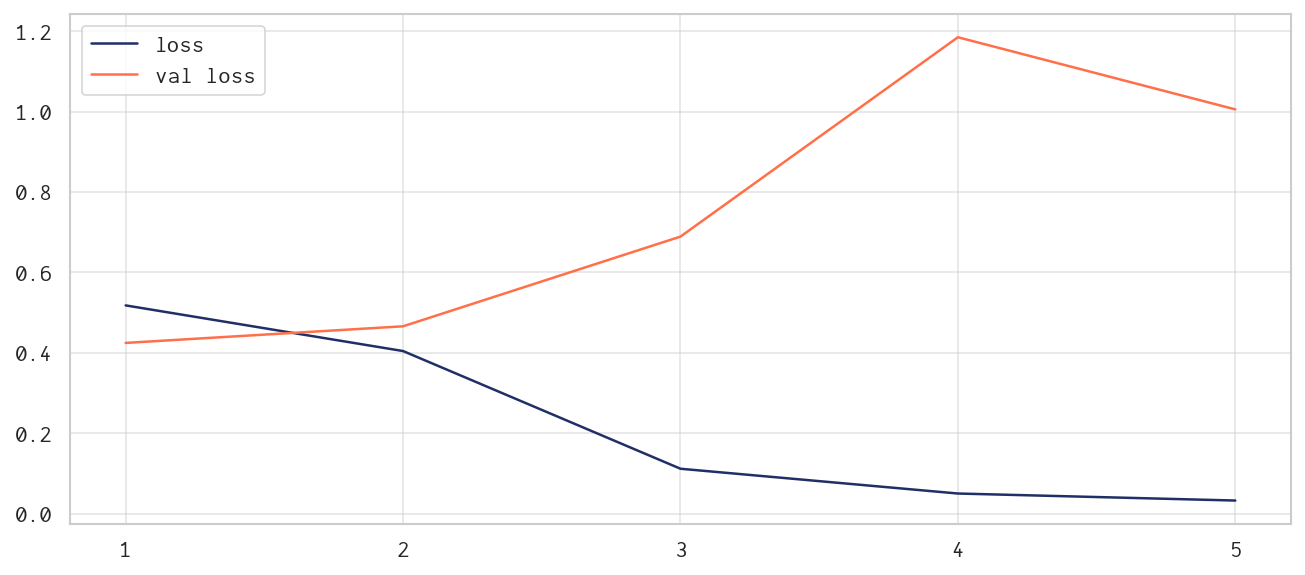

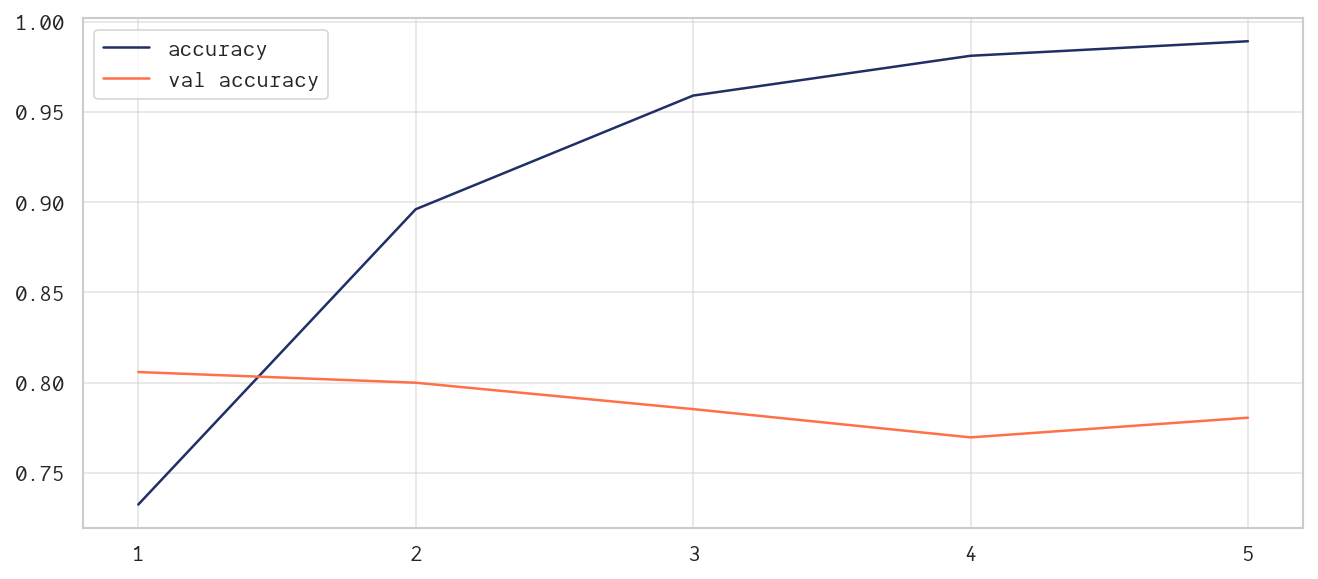

In [37]:
sns.lineplot(epochs, hist.history['loss'], label='loss')
sns.lineplot(epochs, hist.history['val_loss'], label='val loss')
plt.xticks(ticks=epochs)
plt.show()

sns.lineplot(epochs, hist.history['accuracy'], label='accuracy')
sns.lineplot(epochs, hist.history['val_accuracy'], label='val accuracy')
plt.xticks(ticks=epochs)
plt.show()